# overview

In this lab, you will complete a spoken digit recognition using classic machine learning algorithm (k-nearest neighbors  and support vector machine). The task is based on a small audio dataset called `audio-mnists`.

## Scikit-learn package

[official documentation](https://scikit-learn.org/stable/)

scikit-learn, also called `sklearn`, is an open source python-based machine learning toolkit. It implements efficient algorithm applications through python numerical computing libraries such as `NumPy`, `SciPy` and `Matplotlib`, and covers almost all mainstream machine learning algorithms.

To install `sklearn`, just use the `pip` command in your commandline

```
pip install -U scikit-learn
```

> In jupyter notebook, you can use `!<command>` to run shell command.

In [22]:
!pip3 install sklearn
!pip3 install scipy
!pip3 install matplotlib
!pip3 install librosa
!pip3 install numpy
!pip3 install seaborn

## Dataset introduction

>A simple audio/speech dataset consisting of recordings of spoken digits in wav files at 8kHz. The recordings are trimmed so that they have near minimal silence at the beginnings and ends.

The dataset contains 3000 spoken digits. For each sample, The input is an audio .wav file and the output should be an integer between 0-9. The raw audio are recorded in `audio_mnist/recorddings`, where files are named in the following format: `{digitLabel}_{speakerName}_{index}.wav`. For Example: `7_jackson_32.wav`.




In [23]:
import os
import sys
sys.path.append('./')

import numpy as np
from random import shuffle
from scipy.io import wavfile
from librosa import feature
from librosa.util import fix_length

import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

from scipy.stats import norm
import IPython

data_dir = "audio_mnist/recordings"
data_size = 2600

## Step1: Read the raw data and play it in jupyter notebook
here is an audio file `0_george_0.wav`, try playing it!

In [24]:
samplerate, audio = wavfile.read(r"audio_mnist/recordings/1_george_0.wav")
IPython.display.Audio(audio, rate=samplerate)

## Step2: Read the full name of each data file

In [25]:
#first we only read the file name of each data
file_list = os.listdir(data_dir)
print("Data file list: ", file_list[:20])

Data file list:  ['5_nicolas_9.wav', '3_yweweler_14.wav', '1_lucas_5.wav', '2_george_44.wav', '4_yweweler_38.wav', '3_yweweler_28.wav', '4_yweweler_10.wav', '3_george_1.wav', '1_nicolas_15.wav', '1_jackson_42.wav', '0_theo_46.wav', '6_lucas_9.wav', '5_nicolas_48.wav', '9_jackson_43.wav', '9_nicolas_14.wav', '4_nicolas_7.wav', '1_nicolas_29.wav', '4_jackson_0.wav', '1_lucas_43.wav', '5_jackson_23.wav']


## Step3: Split dataset into training data and test data

The dataset contains 3000 samples. We split it into training set (2100 samples) and testing set (900 samples). The testing set, which the model has never seen, is used for measuring its performance.

In [26]:
def test_train_split(data_list, test_ratio=0.3):
    n = len(data_list)
    shuffle(data_list)
    test_list = data_list[:int(n*test_ratio)]
    train_list = data_list[int(n*test_ratio):]
    return train_list, test_list

train_list, test_list = test_train_split(file_list)
train_list

['3_nicolas_4.wav',
 '2_nicolas_44.wav',
 '5_george_19.wav',
 '4_theo_41.wav',
 '3_nicolas_2.wav',
 '6_nicolas_30.wav',
 '7_nicolas_22.wav',
 '3_george_32.wav',
 '9_nicolas_34.wav',
 '2_nicolas_9.wav',
 '7_george_33.wav',
 '8_theo_36.wav',
 '7_nicolas_43.wav',
 '7_lucas_34.wav',
 '8_yweweler_37.wav',
 '7_yweweler_22.wav',
 '8_george_21.wav',
 '9_yweweler_22.wav',
 '3_lucas_14.wav',
 '7_theo_13.wav',
 '9_george_49.wav',
 '4_theo_32.wav',
 '0_george_21.wav',
 '0_george_15.wav',
 '8_theo_4.wav',
 '5_lucas_41.wav',
 '4_lucas_35.wav',
 '4_yweweler_48.wav',
 '4_lucas_11.wav',
 '3_nicolas_5.wav',
 '3_george_40.wav',
 '4_jackson_29.wav',
 '8_lucas_44.wav',
 '2_nicolas_30.wav',
 '4_jackson_40.wav',
 '5_george_27.wav',
 '3_jackson_35.wav',
 '4_jackson_14.wav',
 '7_lucas_4.wav',
 '6_lucas_9.wav',
 '8_george_33.wav',
 '5_yweweler_19.wav',
 '0_lucas_45.wav',
 '0_lucas_14.wav',
 '0_yweweler_35.wav',
 '0_jackson_37.wav',
 '2_yweweler_7.wav',
 '3_george_17.wav',
 '6_jackson_30.wav',
 '2_yweweler_5.wav

print the first 10 datas file name of both training data and testing data. Then print their number.

In [27]:
print("training data: ", train_list[:10], ", total number: ", len(train_list))
print("testing data: ", test_list[:10], ", total number: ", len(test_list))

training data:  ['3_nicolas_4.wav', '2_nicolas_44.wav', '5_george_19.wav', '4_theo_41.wav', '3_nicolas_2.wav', '6_nicolas_30.wav', '7_nicolas_22.wav', '3_george_32.wav', '9_nicolas_34.wav', '2_nicolas_9.wav'] , total number:  2100
testing data:  ['6_yweweler_21.wav', '1_nicolas_49.wav', '8_lucas_11.wav', '5_yweweler_34.wav', '6_theo_5.wav', '8_lucas_35.wav', '3_yweweler_47.wav', '0_theo_31.wav', '1_yweweler_35.wav', '6_george_13.wav'] , total number:  900


## Step4: Read raw data from audio file and stack them as a tensor(matrix)

Each video stream will be read as a numpy array. We then use the [MFCC](https://www.kaggle.com/code/ilyamich/mfcc-implementation-and-tutorial/notebook) to extract its feature, which means convert each data into a vector(120 dimensions). By stacking the 2100 and 900 vectors, the training set and testing set will be a tensor(in this 2 dimensional case, it is a matrix) with dimension of (2100, 120) and (900, 120).


In [28]:
def read_data(dir, file_list):
    labels = []
    datas = []
    for file_name in file_list:
        sample_rate, data = wavfile.read(os.path.join(dir, file_name))
        data = fix_length(data, size=data_size)
        label = int(file_name.split('_')[0])

        #mfcc feature extraction
        data = data.astype(float)
        data = feature.mfcc(y=data, sr=sample_rate, n_fft=1024)

        datas.append(data.flatten())
        labels.append(label)

    return np.stack(datas), np.array(labels, dtype=int)

train_set, train_label = read_data(data_dir, train_list)
test_set, test_label = read_data(data_dir, test_list)

please print the tensor's shape of `train_set`, `test set`, `train label`, and `test label`

In [29]:
print("train set: ", type(train_set).__name__,train_set.shape, "\t", "train label:", type(train_label).__name__, train_label.shape)
print("test set: ", type(test_set).__name__,test_set.shape, "\t", "test label:", type(test_label).__name__, test_label.shape)

train set:  ndarray (2100, 120) 	 train label: ndarray (2100,)
test set:  ndarray (900, 120) 	 test label: ndarray (900,)


Please try different frame numbers of MFCC and comparing the loaded data above to see what is the difference

In [30]:
# to be implemented

## Step5: Preprocessing - Data standardization

the formula:

$$
z = \frac{x-\mu}{\sigma}
$$

where:
- $x$:raw data
- $\mu$: the mean
- $\sigma$: the standard deviation

In [31]:
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data-mu)/sigma

train_set = standardization(train_set)
test_set = standardization(test_set)

check if the data is in standard norm distribution

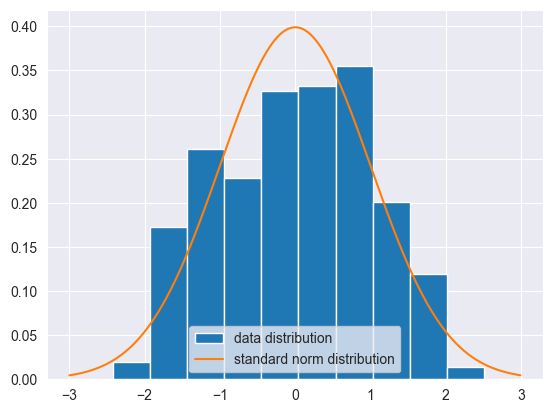

In [32]:
fig, ax = plt.subplots()
ax.hist(train_set[:, 0], density=True, label="data distribution")
x = np.arange(-3, 3, 0.01)
ax.plot(x, norm.pdf(x, 0, 1.), label="standard norm distribution")
plt.legend()

The data now be rescaled into a standard normal distribution, where $\sigma=1$, $u=0$,
please plot the standardized feature of the first data sample in training set.

In [33]:
#to be implemented

## Step6: Implement k-nearest neighbors algorithm, and evaluate with confusion matrix and F1-score
[SKlearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)


In [34]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier(n_neighbors=5, metric="minkowski")
#use the training set to train the model
KNN.fit(train_set, train_label)

test_prediction = KNN.predict(test_set)

the predicted result is stored in `test_prediction`, and the ground truth is stored in `test_label`. print out the first 10 result of prediction result and comparing them with the conresponding ground truth

In [35]:
print("Test label: ", test_label[:10])
print("Test prediction: ", test_prediction[:10])

Test label:  [6 1 8 5 6 8 3 0 1 6]
Test prediction:  [6 1 8 5 6 8 3 0 1 6]


### confusion matrix

Each **row** of the matrix represents the instances in an **actual class** while each **column** represents the instances in a **predicted class**

Text(0.5, 47.7222222222222, 'predicted')

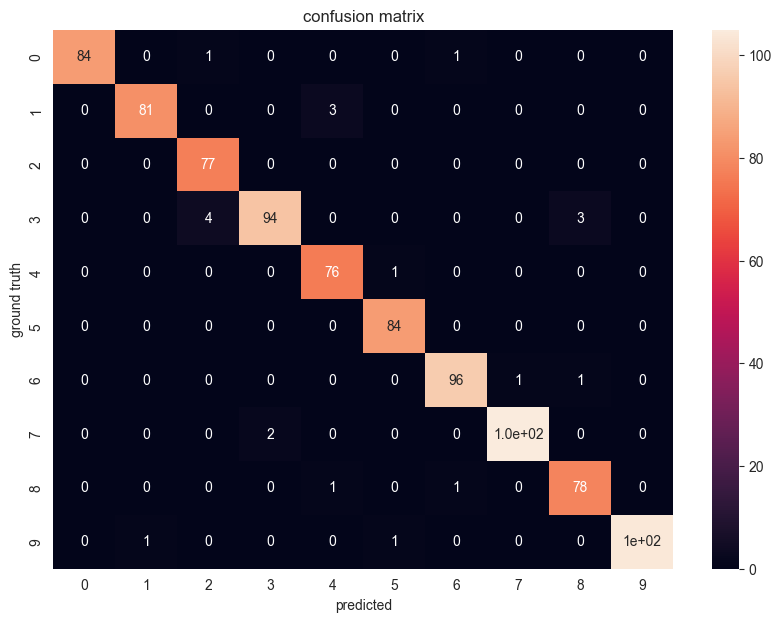

In [36]:
from sklearn.metrics import confusion_matrix, f1_score
mat = confusion_matrix(test_label, test_prediction)
plt.figure(figsize = (10,7))
sn.heatmap(mat, annot=True)
plt.title("confusion matrix")
plt.ylabel("ground truth")
plt.xlabel("predicted")

### F1 score

 the F-score or F-measure is a measure of a test's accuracy. It is calculated from the precision and recall of the test. The highest possible value of an F-score is 1.0, indicating perfect precision and recall, and the lowest possible value is 0, if both precision and recall are zero.

$$
recall = \frac{tp}{tp+fn}
$$

$$
precision = \frac{tp}{tp+fp}
$$

$$
F1score = 2\frac{precision*recall}{precision+recall} = \frac{2tp}{2tp+fp+fn}
$$

where:
$$
tp = truePositive,
tn = trueNegative,
fp = falsePositive,
fn = falseNegative
$$

In [37]:
f1_score(test_label, test_prediction, average="micro")

0.9766666666666667

Now, please build a KNN with different Number of neighbors, and evaluate it with confusion matrix and F1 scores

In [38]:
#to be implemented

## Step7: Implement Support vector machine, and evaluate with confusion matrix and F1 scores
[SKlearn documentation](https://scikit-learn.org/stable/modules/svm.html)

In [39]:
from sklearn.svm import SVC

svc = SVC(gamma="auto", kernel="rbf")
svc.fit(train_set, train_label)
test_prediction_svm = svc.predict(test_set)

print("Test label: ", test_label[:20])
print("Test prediction: ", test_prediction_svm[:20])

Test label:  [6 1 8 5 6 8 3 0 1 6 3 1 3 7 6 4 7 0 7 1]
Test prediction:  [6 1 8 4 6 8 3 0 1 6 3 1 3 7 6 4 3 0 7 1]


### confusion matrix

Text(0.5, 47.7222222222222, 'predicted')

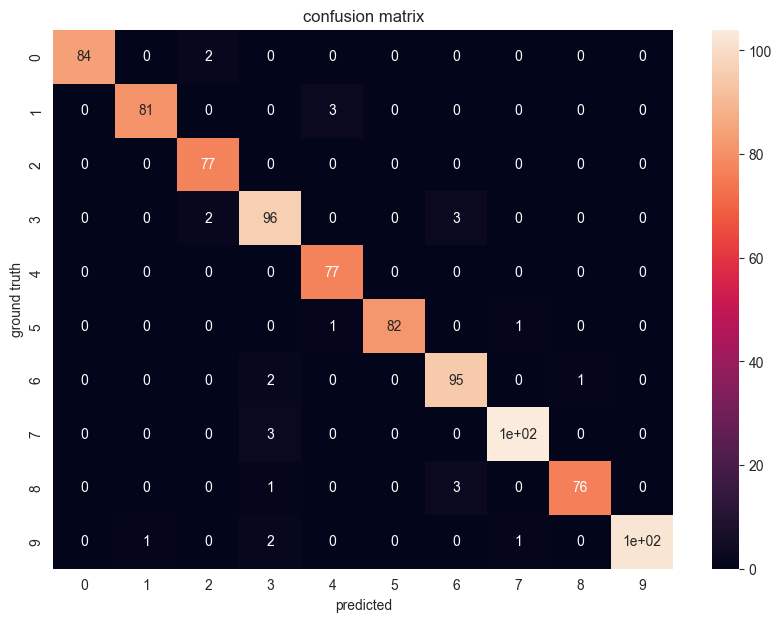

In [40]:
mat = confusion_matrix(test_label, test_prediction_svm)
plt.figure(figsize = (10,7))
sn.heatmap(mat, annot=True)
plt.title("confusion matrix")
plt.ylabel("ground truth")
plt.xlabel("predicted")

### F1 score

In [41]:
f1_score(test_label, test_prediction_svm, average="micro")

0.9711111111111111

Now, please implement SVM with different kernel function and evaluate with confusion matrix and F1 socre

In [42]:
#to be implemented